<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [116]:
from numpy import linspace
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

from ydata_profiling import ProfileReport

Откроем наш датасет, проверим, что с ним всё в порядке, посмотрим на общую информацию.

In [11]:
data = pd.read_csv('/datasets/Churn.csv')

In [12]:
profile = ProfileReport(data, title='Churn')

In [13]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [15]:
data.shape

(10000, 14)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Датасет практически в полном порядке. Однако, присутствуют пропуски в столбце Tenure. Почему? Проверим, возможно, это те клиенты, которые ещё не ушли из банка.

In [17]:
data[data.Tenure.isna() & data.Exited == 1]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
125,126,15627360,Fuller,432,France,Male,42,NaN,152603.45,1,1,0,110265.24,1
237,238,15764866,Synnot,539,Germany,Female,43,NaN,116220.50,3,1,0,55803.96,1
357,358,15661629,Ricci,522,Spain,Male,34,NaN,126436.29,1,1,0,174248.52,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9337,9338,15797751,Pai,466,Germany,Female,47,NaN,102085.72,1,1,1,183536.24,1
9466,9467,15592716,Clarke,559,France,Male,52,NaN,0.00,1,1,0,129013.59,1
9652,9653,15726720,Blinova,480,France,Female,40,NaN,0.00,1,1,0,170332.67,1
9858,9859,15619514,Bull,507,Germany,Male,40,NaN,120105.43,1,1,0,92075.01,1


Гипотеза не подтвердилась. Отсутствие значения не означает, что клиент всё ещё является клиентом банка. Отбросим эти значения.

In [18]:
data = data[~data.Tenure.isna()]

In [19]:
data.shape

(9091, 14)

Закодируем категориальные переменные.

In [20]:
data = pd.get_dummies(data, drop_first=True, columns=['Geography', 'Gender'])

In [21]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [22]:
data.shape

(9091, 15)

Уберём лишние столбцы.

In [23]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [24]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Посмотрим на баланс классов.

In [25]:
len(data[data.Exited == 0]) / len(data)

0.7960620393796062

Датасет не сбалансирован.

Разобьём наши данные на обучающую, валидационную и тестовую выборки.

In [26]:
target = data['Exited']
features = data.drop('Exited', axis=1)

In [27]:
RANDOM_STATE = 12345

In [30]:
features_train, features_tv, target_train, target_tv = train_test_split(
features, target, train_size=0.6, random_state=RANDOM_STATE, stratify=target)

In [31]:
features_valid, features_test, target_valid, target_test = train_test_split(
features_tv, target_tv, test_size=0.5, random_state=RANDOM_STATE, stratify=target_tv)

## Исследование задачи

Начнём с dummy-классификатора, чтобы у нас был некоторый baseline.

In [32]:
dummy = DummyClassifier(random_state=12345)

In [33]:
dummy.fit(features_train, target_train)

DummyClassifier(random_state=12345)

In [34]:
preds = dummy.predict(features_valid)

In [35]:
f1_score(target_valid, preds)

0.0

In [36]:
roc_auc_score(target_valid, preds)

0.5

Предсказуемо.

Попробуем обучить случайный лес.

In [105]:
rf = RandomForestClassifier(random_state=12345)

In [106]:
rf.fit(features_train, target_train)

RandomForestClassifier(random_state=12345)

In [107]:
preds = rf.predict(features_valid)

In [108]:
f1_score(target_valid, preds)

0.6019736842105263

In [117]:
cm = confusion_matrix(target_valid, preds)

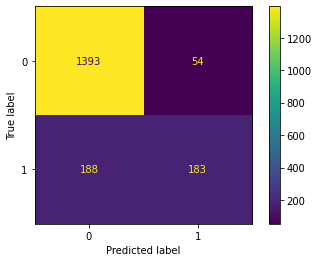

In [123]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [124]:
roc_auc_score(target_valid, preds)

0.7279714326695068

Очень хороший результат. Попробуем логистическую регрессию.

In [125]:
lr = LogisticRegression(random_state=12345)

In [126]:
lr.fit(features_train, target_train)

LogisticRegression(random_state=12345)

In [127]:
preds = lr.predict(features_valid)

In [128]:
f1_score(target_valid, preds)

0.07637231503579953

In [130]:
cm = confusion_matrix(target_valid, preds)

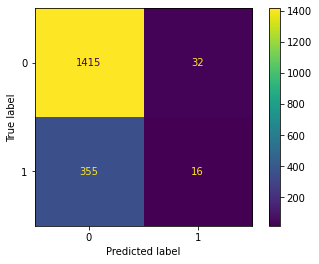

In [131]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [132]:
roc_auc_score(target_valid, preds)

0.5105059822627726

Попробуем настроить гиперпараметры.

In [133]:
lr = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1')

In [134]:
lr.fit(features_train, target_train)

LogisticRegression(penalty='l1', random_state=12345, solver='liblinear')

In [135]:
preds = lr.predict(features_valid)

In [136]:
f1_score(target_valid, preds)

0.32399999999999995

In [138]:
cm = confusion_matrix(target_valid, preds)

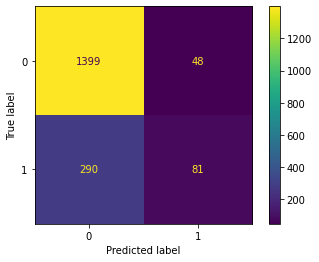

In [139]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [140]:
roc_auc_score(target_valid, preds)

0.592578380402245

Стало немного лучше. Попробуем алгоритм K-ближайших соседей.

In [141]:
knn = KNeighborsClassifier()

In [142]:
knn.fit(features_train, target_train)

KNeighborsClassifier()

In [143]:
preds = knn.predict(features_valid)

/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [144]:
f1_score(target_valid, preds)

0.10141987829614603

In [146]:
cm = confusion_matrix(target_valid, preds)

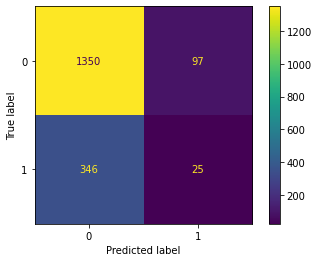

In [147]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [148]:
roc_auc_score(target_valid, preds)

0.5001750997043796

Невысокий результат.

Были рассмотрены 3 алгоритма: случайный лес, логистическая регрессия и K-ближайших соседей. Наилучшие результаты показал первый алгоритм. Однако, желаемый результат дотигнут не был, следовательно, необходимо обратитьсяк методом борьбы с дисбалансом.

## Борьба с дисбалансом

Попробуем сбалансировать классы.

In [149]:
rf_balanced = RandomForestClassifier(random_state=12345, class_weight='balanced')

In [150]:
rf_balanced.fit(features_train, target_train)

RandomForestClassifier(class_weight='balanced', random_state=12345)

In [151]:
preds = rf_balanced.predict(features_valid)

In [152]:
f1_score(target_valid, preds)

0.5733788395904437

In [154]:
cm = confusion_matrix(target_valid, preds)

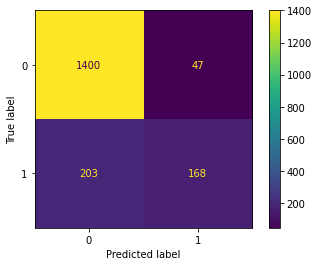

In [155]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [156]:
roc_auc_score(target_valid, preds)

0.7101745967584201

Результат несколько ухудшился в сравнении с несбалансированным алгоритмом. Попробуем настроить гиперпараметры.

In [62]:
ests = linspace(100, 1000, 10, dtype=int)

In [63]:
crits = ('gini', 'entropy')

In [64]:
params = {'n_estimators': ests, 'criterion': crits}

In [65]:
rf_balanced = RandomForestClassifier(random_state=12345, class_weight='balanced')

In [66]:
clf = GridSearchCV(estimator=rf_balanced, param_grid=params, verbose=3, scoring='f1')

In [67]:
clf.fit(features_train, y=target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...............criterion=gini, n_estimators=100; total time=   0.5s
[CV 2/5] END ...............criterion=gini, n_estimators=100; total time=   0.5s
[CV 3/5] END ...............criterion=gini, n_estimators=100; total time=   0.5s
[CV 4/5] END ...............criterion=gini, n_estimators=100; total time=   0.5s
[CV 5/5] END ...............criterion=gini, n_estimators=100; total time=   0.5s
[CV 1/5] END ...............criterion=gini, n_estimators=200; total time=   1.1s
[CV 2/5] END ...............criterion=gini, n_estimators=200; total time=   1.1s
[CV 3/5] END ...............criterion=gini, n_estimators=200; total time=   1.1s
[CV 4/5] END ...............criterion=gini, n_estimators=200; total time=   1.1s
[CV 5/5] END ...............criterion=gini, n_estimators=200; total time=   1.1s
[CV 1/5] END ...............criterion=gini, n_estimators=300; total time=   1.6s
[CV 2/5] END ...............criterion=gini, n_e

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'criterion': ('gini', 'entropy'),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='f1', verbose=3)

In [68]:
preds = clf.best_estimator_.predict(features_valid)

In [69]:
f1_score(target_valid, preds)

0.5902192242833052

In [70]:
roc_auc_score(target_valid, preds)

0.7196085590225711

Неплохой результат, но этого недостаточно. Обратимся к логистической регрессии.

In [72]:
lr_balanced = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', class_weight='balanced')

In [73]:
lr_balanced.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', penalty='l1', random_state=12345,
                   solver='liblinear')

In [74]:
preds = lr_balanced.predict(features_valid)

In [75]:
f1_score(target_valid, preds)

0.508411214953271

In [76]:
roc_auc_score(target_valid, preds)

0.7190301711692748

Результат заметно улучшился в сравнении с небалансируемой моделью. Поробуем настроить гиперпараметры.

In [77]:
c = (1, 0.1, 0.01, 0.001)

In [78]:
params = {'C': c}

In [79]:
clf = GridSearchCV(estimator=lr_balanced, param_grid=params, verbose=3, scoring='f1')

In [80]:
clf.fit(features_train, y=target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ............................................C=1; total time=   0.1s
[CV 2/5] END ............................................C=1; total time=   0.2s
[CV 3/5] END ............................................C=1; total time=   0.2s
[CV 4/5] END ............................................C=1; total time=   0.2s
[CV 5/5] END ............................................C=1; total time=   0.2s
[CV 1/5] END ..........................................C=0.1; total time=   0.2s
[CV 2/5] END ..........................................C=0.1; total time=   0.2s
[CV 3/5] END ..........................................C=0.1; total time=   0.2s
[CV 4/5] END ..........................................C=0.1; total time=   0.2s
[CV 5/5] END ..........................................C=0.1; total time=   0.2s
[CV 1/5] END .........................................C=0.01; total time=   0.2s
[CV 2/5] END ....................................

GridSearchCV(estimator=LogisticRegression(class_weight='balanced', penalty='l1',
                                          random_state=12345,
                                          solver='liblinear'),
             param_grid={'C': (1, 0.1, 0.01, 0.001)}, scoring='f1', verbose=3)

In [81]:
preds = clf.best_estimator_.predict(features_valid)

In [82]:
f1_score(target_valid, preds)

0.5055970149253731

In [83]:
roc_auc_score(target_valid, preds)

0.716645834769213

Неплохой, но недостаточно высокий результат. Попробуем downsampling.

In [84]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [85]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

Обучим случайный лес.

In [86]:
rf_ds = RandomForestClassifier(random_state=12345, criterion='entropy')

In [87]:
rf_ds.fit(features_downsampled, target_downsampled)

RandomForestClassifier(criterion='entropy', random_state=12345)

In [88]:
preds = rf_ds.predict(features_valid)

In [89]:
f1_score(target_valid, preds)

0.6284153005464481

In [90]:
roc_auc_score(target_valid, preds)

0.764706978095772

Уменьшение выборки оказалось эффективным. Попробуем логистическую регрессию.

In [91]:
lr_ds = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1')

In [92]:
lr_ds.fit(features_downsampled, target_downsampled)

LogisticRegression(penalty='l1', random_state=12345, solver='liblinear')

In [93]:
preds = lr_ds.predict(features_valid)

In [94]:
f1_score(target_valid, preds)

0.5118219749652295

In [95]:
roc_auc_score(target_valid, preds)

0.6913094663743371

Не очень хороший результат. Обратимся к алгоритму K-ближайших соседей.

In [96]:
knn_ds = KNeighborsClassifier()

In [97]:
knn_ds.fit(features_downsampled, target_downsampled)

KNeighborsClassifier()

In [98]:
preds = knn_ds.predict(features_valid)

/opt/conda/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [99]:
f1_score(target_valid, preds)

0.22164948453608246

In [100]:
roc_auc_score(target_valid, preds)

0.5056749069084285

Было рассмотрено 2 способа борьбы с дисбалансом классов: взвешивание классов и уменьшение выборки. Втоорой способ оказался достаточно эффективным. Лучший результат показал снова случайный лес.

## Тестирование модели

In [157]:
preds = rf_ds.predict(features_test)

In [158]:
f1_score(target_test, preds)

0.6049723756906077

In [162]:
cm = confusion_matrix(target_test, preds)

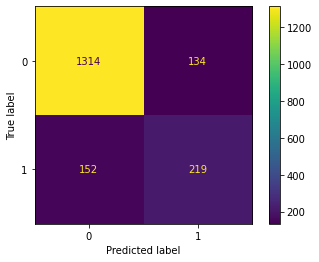

In [163]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [164]:
roc_auc_score(target_test, preds)

0.7488775297463924

Желаемый результат достигнут.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*